# DWI Workshop - Fiber Tracking 

In general we need a wy to determine the principal dirrections from the diffusion data set, a set of stopping crietia, and a set of seeeds from which to begin tracking. 


In [21]:
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data
import nibabel as nib
import os 
import matplotlib.pyplot as plt
import numpy as np
from dipy.reconst.csdeconv import auto_response_ssst
# from dipy.reconst.csdeconv import auto_response_msmt
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.viz import window, actor, has_fury
from PIL import Image
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy. tracking.streamline import Streamlines

In [2]:
datadir = '../Day2/data/stanford_hardi/'
label_fname = get_fnames('stanford_labels')

data = nib.load(os.path.join(datadir, 'HARDI150.nii.gz')).get_fdata()
bvals, bvecs = read_bvals_bvecs(os.path.join(datadir, 'HARDI150.bval'), 
                               os.path.join(datadir, 'HARDI150.bvec'))


labels = nib.load(os.path.join(label_fname)).get_fdata()
print(labels.shape)

(81, 106, 76)


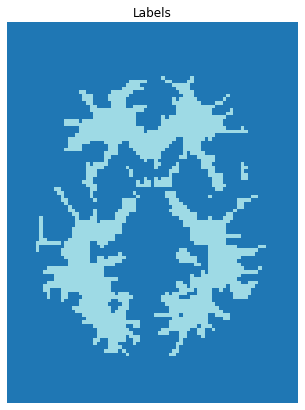

In [3]:
# create a white matter mask. 
white_matter = (labels==1) | (labels==2)
plt.figure(figsize=(7,7))
plt.imshow(np.rot90(white_matter[:,:,30]),cmap='tab20'), plt.axis('off'), plt.title('Labels')
plt.show()
# will add MSMT later

In [4]:
# Need to get ODFs to estimate directions from the diffusion dataset, estimated from the peaks of an ODF. 
gtab = gradient_table(bvals, bvecs)
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

In [14]:
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere, relative_peak_threshold=0.8, min_separation_angle=45,
                            mask=white_matter)

In [6]:
interactive=True
if has_fury: 
    scene = window.Scene()
    scene.add(actor.peak_slicer(csa_peaks.peak_dirs, csa_peaks.peak_values, colors=None))
    
    window.record(scene, out_path='csa_direction_field.png', size=(900,900))



(<matplotlib.image.AxesImage at 0x7fb5d7fbce80>, (-0.5, 99.5, 99.5, -0.5))

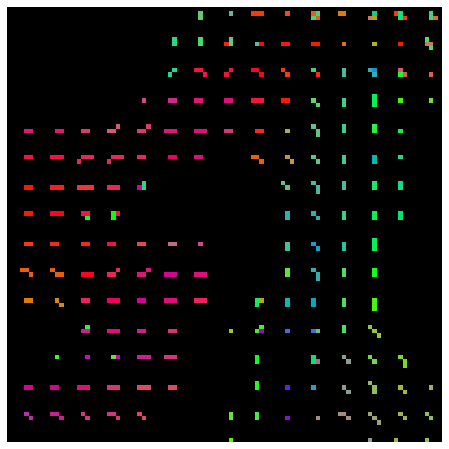

In [12]:
plt.figure(figsize=(8,8))
tmp = np.array(Image.open('csa_direction_field.png'))
plt.imshow(tmp[300:400, 300:400,:]), plt.axis('off')

In [15]:
stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, 0.25)

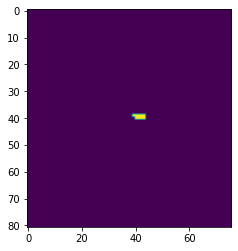